Импортируем необходимые библиотеки

In [34]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.onnx
import torchvision

Располодение датасета

In [22]:
#получим такой адрес как C:\\(папка с блокнотом)
dir = os.path.abspath(os.curdir)#путь к файлу
# наши папки находятся в каталоге directory 
data_dir=os.path.join(dir, "datasets\\")

Трансформируем изображения нужным образом в нашем случае мы уменьшаем его до 224*224 пикселя

In [23]:
#Масштабирование и нормализация данных для обучения и тестирования в resnet18
data_transforms = {
    'train': transforms.Compose([#связываем вместе
        transforms.RandomResizedCrop(224),#обрезка произвольной части и изменение размера до нужного
        transforms.RandomHorizontalFlip(),#поворот относительно горизонтальной оси с заданной вероятностью
        transforms.ToTensor(),#преобразование изображения в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#нормализация тензорного изображения со средним значением и стендартным отклонением
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


Функция, которая преобразует картинки в массив данных для обучения

In [24]:
#Создаём функцию для получения набора данных изображений и изменения его размера в соответствии с размером модели
def get_dataset(data_dir, data_transforms ):
    # создаём тестовую и тренировочную выборки
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),#загрузчик данных(соединение компонентов пути)
                                              data_transforms[x])
                      for x in ['train', 'test']}#итерация по набору данных
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    #получим классы из названия папок набора данных для тренировки модели
    classes = image_datasets['train'].classes

    return dataloaders["train"], dataloaders['test'], classes, dataset_sizes

Классы картинок и количество в тренировочной и тестовой выборках

Classes:  ['Healthy', 'Tach']
The datasest have:  {'train': 270, 'test': 50}  images


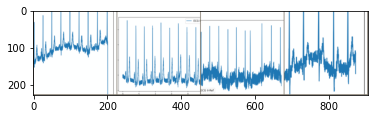

Healthy Healthy Healthy  Tach


In [26]:
#данные о выборках
trainloader, testloader, classes, dataset_sizes=get_dataset(data_dir, data_transforms)
print('Classes: ',  classes)
print('The datasest have: ',  dataset_sizes ," images")
# Создаём новую функцию отображения изображений для новой трансформации 
def imshow_resNet18(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))#транспонирование
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)#ограничение значений в интервале
    plt.imshow(inp)#вывод данных изображением
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # делаем небольшую паузу, позволяющую графикам обновиться
# получаем несколько случайных изображений из выборки
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()
# выводим изображения
imshow_resNet18(torchvision.utils.make_grid(images))
# и названия
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Создаём слои с различными разностями входа и выхода и функции, отвечающие за преобразования

In [37]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())# возвращает полную копию 
    best_acc = 0.0

    for epoch in range(num_epochs):#печать данных для каждой эпохи
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Каждая эпоха имеет этап обучения и проверки
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # переводим модель в режим обучения
            else:
                model.eval()   # оценка модели
            running_loss = 0.0 #обнуляем всё
            running_corrects = 0
            # итерация по данным
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # обнулите градиенты параметров
                optimizer.zero_grad()
                # вперёд
                # история отслеживания если только в тренировочной
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # обратная оптимизация + только в том случае, если она находится на этапе обучения
                    if phase == 'train':
                        loss.backward()#градиент текущего тензора
                        optimizer.step()#оптимизация шага
                # статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()#скорость обучения в зависимости от числа шагов
            epoch_loss = running_loss / dataset_sizes[phase]#результативность
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # глубокое копирование модели
            if phase == 'test' and epoch_acc > best_acc:#выбор лучшего
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # загружаем лучший результат модели
    model.load_state_dict(best_model_wts)
    return model

In [28]:
# Подготовим параметры для обучения модели
dataloaders = {'train': trainloader, 'test': testloader}
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Здесь размер каждой выходной выборки установлен равным 2.
# В качестве альтернативы, это может быть обобщено на nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Все параметры оптимизируются
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Уменьшение LR в 0,1 раза каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Тренируем нашу модель

In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9284 Acc: 0.5481
test Loss: 0.5145 Acc: 0.7200

Epoch 1/9
----------
train Loss: 0.8630 Acc: 0.6074
test Loss: 0.4874 Acc: 0.8200

Epoch 2/9
----------
train Loss: 0.8353 Acc: 0.6000
test Loss: 0.4078 Acc: 0.8000

Epoch 3/9
----------
train Loss: 0.8237 Acc: 0.6333
test Loss: 0.5160 Acc: 0.7800

Epoch 4/9
----------
train Loss: 0.7354 Acc: 0.6259
test Loss: 0.6309 Acc: 0.7200

Epoch 5/9
----------
train Loss: 0.7444 Acc: 0.6333
test Loss: 0.5898 Acc: 0.7200

Epoch 6/9
----------
train Loss: 0.5685 Acc: 0.7074
test Loss: 0.3695 Acc: 0.8000

Epoch 7/9
----------
train Loss: 0.6028 Acc: 0.6778
test Loss: 0.3517 Acc: 0.8600

Epoch 8/9
----------
train Loss: 0.5534 Acc: 0.7037
test Loss: 0.3483 Acc: 0.8400

Epoch 9/9
----------
train Loss: 0.5721 Acc: 0.6889
test Loss: 0.3578 Acc: 0.8400

Training complete in 10m 6s
Best val Acc: 0.860000


Визуализация результатов анализа тестовых данных

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.3177, -0.2938])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.0749, 2.4553])
Predict class - Tach, real class - Healthy, probability (Healthy,Tach) - tensor([-0.9730,  2.0800])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.8701, 0.1828])


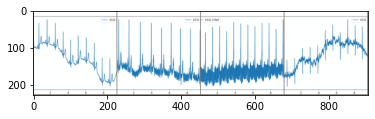

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.4812,  3.2262])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.6523,  2.6387])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.1241,  3.1378])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([1.1799, 1.3599])


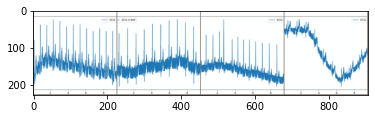

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.4796, -0.3894])
Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([1.9664, 0.0812])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.4969, -0.0076])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.4739, -0.7749])


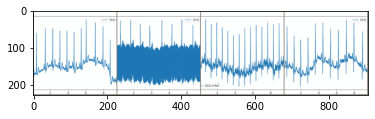

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.1400, 0.4006])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.6395, -0.4095])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.2704,  1.9377])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.7146,  1.3169])


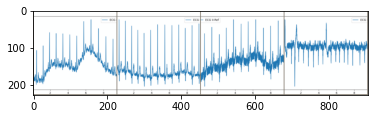

Predict class - Tach, real class - Healthy, probability (Healthy,Tach) - tensor([0.4929, 1.6293])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([0.9185, 0.6714])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.1722, -0.5513])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([2.2467, 0.0685])


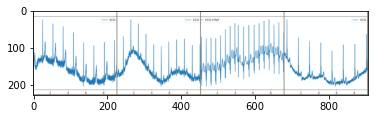

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.4831, -0.0343])
Predict class - Tach, real class - Healthy, probability (Healthy,Tach) - tensor([0.3522, 2.3269])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 3.1495, -0.7166])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.4247,  2.2326])


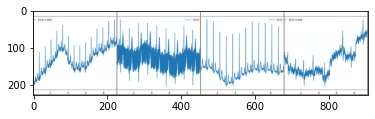

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.7028,  2.7035])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.7175, -0.9299])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 3.5617, -0.7838])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.6304, -0.3727])


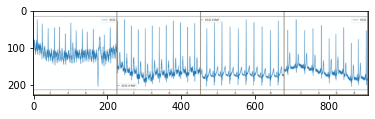

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.5966, -0.8572])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.1434,  2.7246])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.8932, -0.3100])
Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([1.3400, 0.3452])


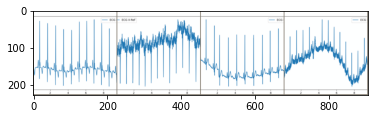

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.7294,  1.3137])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-2.0412,  3.3497])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.2327, -0.1597])
Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([1.3343, 0.5253])


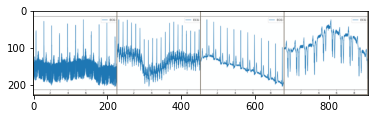

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-1.5936,  2.2746])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.2869, 0.7884])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.7389, 0.0724])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([1.8779, 0.1793])


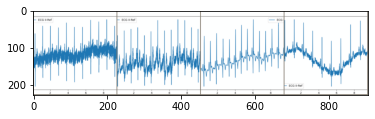

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-2.3043,  3.1120])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.5863,  1.5716])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.3684,  1.9093])
Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 2.7014, -0.6763])


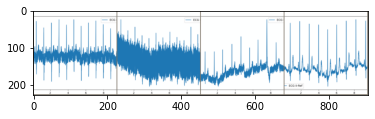

Predict class - Healthy, real class - Healthy, probability (Healthy,Tach) - tensor([ 1.8203, -0.2571])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.2007,  1.8632])
Predict class - Healthy, real class - Tach, probability (Healthy,Tach) - tensor([0.7371, 0.3895])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([0.9758, 1.0119])


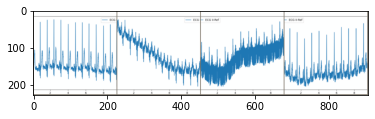

Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.0931,  1.7079])
Predict class - Tach, real class - Tach, probability (Healthy,Tach) - tensor([-0.4444,  2.4604])


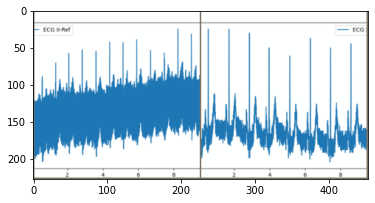

Accuracy of the network on the 50 test images: 86 %


In [32]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
      
        for printdata in list(zip(predicted,labels,outputs)):
            printclass =[classes[int(printdata[0])],classes[int(printdata[1])]]
            print('Predict class - {0}, real class - {1}, probability ({2},{3}) - {4}'.format( printclass[0],printclass[1],
                                                                              classes[0], classes [1],printdata[2]))

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        imshow_resNet18(torchvision.utils.make_grid(images))
        #print('GroundTruth: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('Accuracy of the network on the', dataset_sizes['test'], 'test images: %d %%' % (
    100 * correct / total))